# Projeto análise de dados: Pipeline de dados de Bot de Telegram

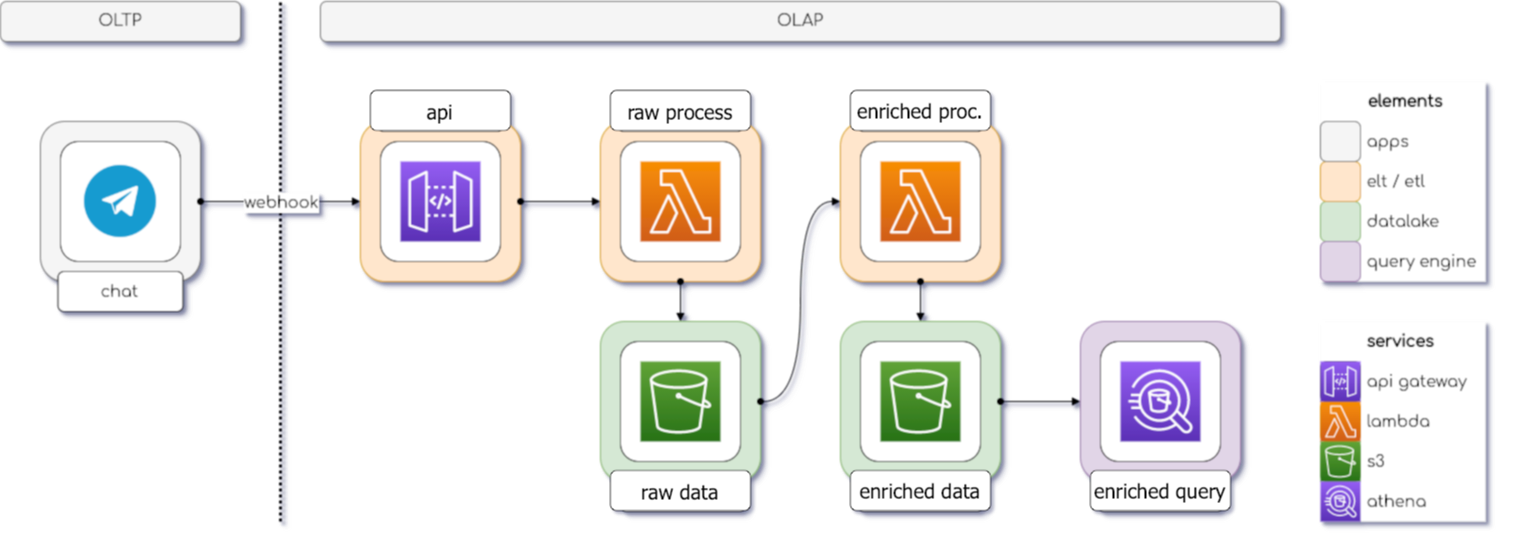

## Introdução

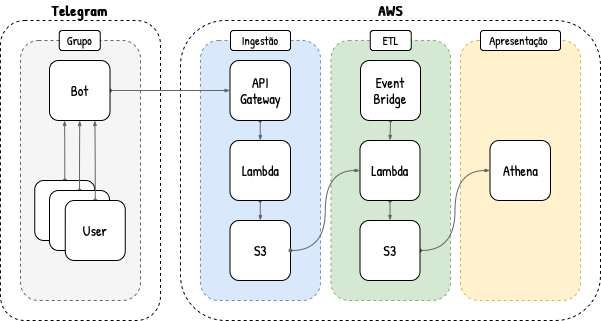

Nesse Projeto será construído um bot do Telegram com o objetivo de fazer um pipeline de dados com as conversas do Telegram, com intuito de simular um bot para ajudar o usuário com alguma dúvida, envolvendo etapas de ingestão de dados, ETL e apresentação no ambiente da Amazon Web Service.

## Pré-Processamento

Importando as bibliotecas:

In [3]:
import os
import pandas as pd
import logging
from datetime import datetime, timezone, timedelta
import json
import requests
from getpass import getpass
import seaborn as sns

import pyarrow as pa
import pyarrow.parquet as pq

## BOT do Telegram

A princípio vamos desenvolver o chatbot do Telegram. Abrimos o chat com o botfather e definimos o nome e as configurações do bot e adicionamos ao grupo em que ele fará interações com os usuários do grupo.

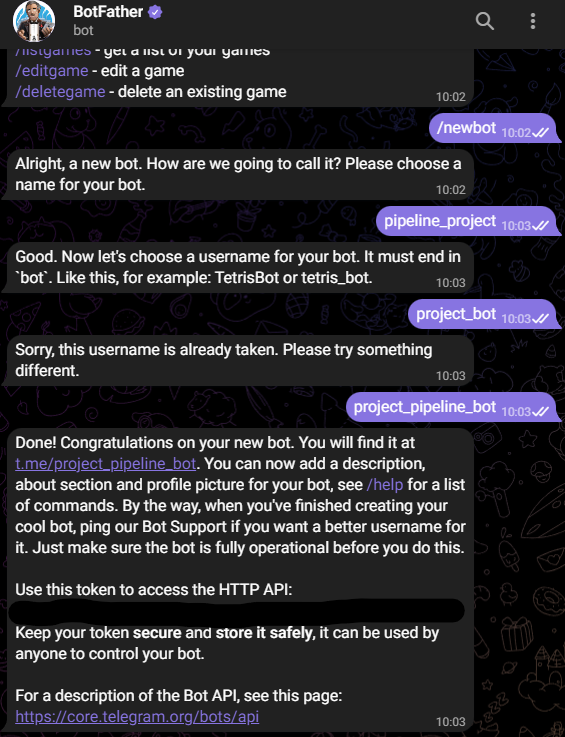

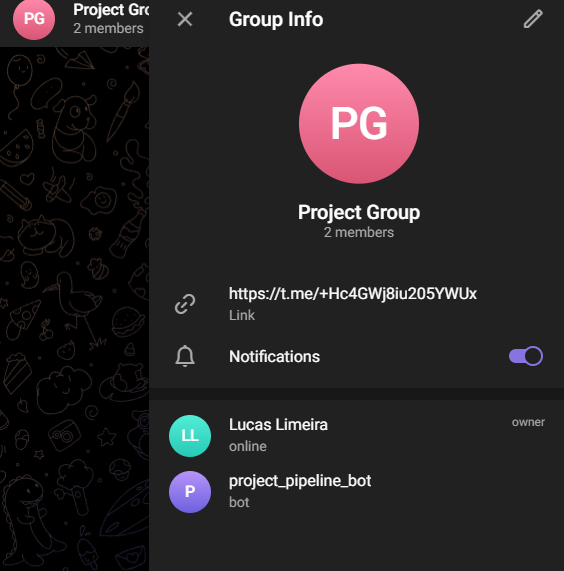

* **Preparando o BOT**:

Nessa parte precisamos inserir o token que é dado na hora que criamos o bot.

In [ ]:
from getpass import getpass

token = getpass()

··········


* **Dados do BOT**:

In [ ]:
base_url = f'https://api.telegram.org/bot{token}'

-> getME

Irá retornar informações sobre o Bot.

In [ ]:
response = requests.get(url=f'{base_url}/getMe')


print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 7171806595,
    "is_bot": true,
    "first_name": "pipeline_project",
    "username": "project_pipeline_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false,
    "can_connect_to_business": false
  }
}


-> getUpdates

Retorna as mensagens capturadas pelo Bot.

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 852419998,
      "message": {
        "message_id": 3,
        "from": {
          "id": 6468181192,
          "is_bot": false,
          "first_name": "Lucas",
          "last_name": "Limeira",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002034756065,
          "title": "Project Group",
          "type": "supergroup"
        },
        "date": 1715261875,
        "text": "Ol\u00e1, mundo!"
      }
    },
    {
      "update_id": 852419999,
      "message": {
        "message_id": 4,
        "from": {
          "id": 6468181192,
          "is_bot": false,
          "first_name": "Lucas",
          "last_name": "Limeira",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002034756065,
          "title": "Project Group",
          "type": "supergroup"
        },
        "date": 1715261944,
        "text": "teste"
      }
    }
  ]
}


| chave | tipo valor | opcional | descrição |
| -- | -- | -- | -- |
| updated_id | int | não | id da mensagem enviada ao **bot** |
| message_id | int | não | id da mensagem enviada ao grupo |
| from_id | int | sim | id do usuário que enviou a mensagem |
| from_is_bot | bool | sim | se o usuário que enviou a mensagem é um **bot** |
| from_first_name | str | sim | primeiro nome do usário que enviou a mensagem |
| chat_id | int | não | id do *chat* em que a mensagem foi enviada |
| chat_type | str | não | tipo do *chat*: private, group, supergroup ou channel |
| date | int | não | data de envio da mensagem no formato unix |
| text | str | sim | texto da mensagem |

## Ingestão

A fase de ingestão é encarregada de receber os dados transacionais em ambientes analíticos. Em geral, os dados são armazenados no formato original, sem alterações no conteúdo ou na estrutura (schema). Por exemplo, se os dados são provenientes de uma API web com formato REST, eles são persistidos no formato JSON. Essa abordagem oferece vantagens, como a capacidade de reprocessamento.

Existem duas maneiras de realizar a ingestão:

* **Batch**: Os dados são ingeridos em blocos em intervalos definidos, geralmente horas ou dias.

* **Streaming**: Os dados são ingeridos à medida que são gerados e disponibilizados.

No contexto deste projeto, as mensagens capturadas pelo bot no Telegram são ingeridas por meio da API web de bots do Telegram, entregues no formato JSON. Como o Telegram retém mensagens por apenas 24 horas em seus servidores, a ingestão via streaming é a escolha ideal. Para possibilitar esse tipo de ingestão, é utilizado um webhook para redirecionar automaticamente as mensagens para outra API web.

Para implementar isso, é necessário um serviço da AWS que forneça uma API web para receber os dados redirecionados, o `AWS API Gateway`. Conectando-o ao `AWS Lambda`, as mensagens são então armazenadas no seu formato original (JSON) em um bucket do `AWS S3`. Essa abordagem permite que sistemas reajam a eventos, sendo classificados como event-driven.

Portanto, precisamos:


 - Criar um *bucket* no `AWS S3`;
 - Criar uma função no `AWS Lambda`;
 - Criar uma API *web* no `AWS API Gateway`;
 - Configurar o *webhook* da API de *bots* do **Telegram**.


### AWS S3




Durante a fase de ingestão, o `AWS S3` atua como um repositório passivo para armazenar as mensagens coletadas pelo bot do Telegram em seu formato original, que é JSON. Para isso, é suficiente criar um bucket, seguindo o padrão de adicionar o sufixo `-raw` ao nome do bucket. É importante observar que um `data lake` é um repositório de dados em grande escala, organizado em zonas que contêm réplicas dos dados em diferentes estágios de processamento. As zonas comuns incluem raw, enriched, ou, em alguns casos, bronze, silver e gold.

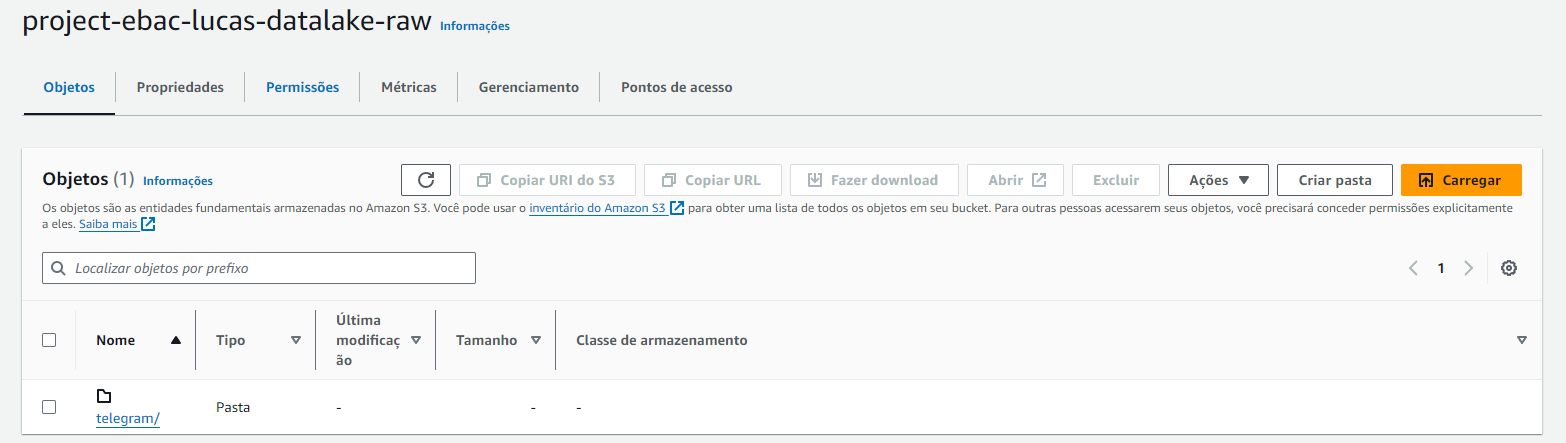

### AWS Lambda



Durante a fase de ingestão, o `AWS Lambda` desempenha o papel ativo de armazenar as mensagens recebidas pelo bot do Telegram em um bucket do `AWS S3`. Para isso, criamos uma função que opera da seguinte forma:

* Recebe a mensagem como parâmetro event;
* Verifica se a mensagem é proveniente do grupo correto no Telegram;
* Armazena a mensagem no formato JSON no bucket do AWS S3;
* Retorna uma mensagem de sucesso à API de bots do Telegram com um código de retorno HTTP igual a 200.

É importante notar que, no Telegram, a opção de adicionar o bot a grupos pode ser restrita, mas ainda é possível iniciar uma conversa em um chat privado.

Abaixo temos o código da função que será executada no ambiente:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser feitas.



*   **variáveis de ambiente**



O código mencionado requer a configuração de duas variáveis de ambiente: `AWS_S3_BUCKET`, que deve conter o nome do bucket do `AWS S3`, e `TELEGRAM_CHAT_ID`, que deve conter o ID do chat do grupo no Telegram. Para adicionar essas variáveis em uma função do `AWS Lambda`, basta acessar as configurações e selecionar a opção de variáveis de ambiente no console da função. É importante destacar que as variáveis de ambiente são uma maneira segura de armazenar informações sensíveis.

> Definimos as duas chaves que estamos usando o `AWS_S3_BUCKET` e o `TELEGRAM_CHAT_ID` e os seus respectivos valores, o qual são o nome do **bucket** criado e o id do grupo que verificamos anteriormente com o **getUpdates**. Vale lembrar que id de grupos são negativos e de usuários positivos.



*   **Permissão**


Por fim, precisamos adicionar a permissão de escrita no *bucket* do `AWS S3` para a função do `AWS Lambda` no `AWS IAM`.


> Agora é o momento que adicionar as permissões necessárias. Bastando clicar no nome da função e sendo direcionado para o `AWS IAM`.

> Então anexamos as políticas de permissões para o nosso bucket, selecionamos acesso total, apesar de não ser o ideal, devido a diversos riscos envolvidos, foi feito apenas para por ser um modo mais dinámico, porém, na prática é necessário limitações em relação ao acesso do bucket.

> Aqui colamos o conteúdo da mensagem que capturamos anteriormente com o getUpdates e executamos o teste com o código da função.

### API Gateway

> Nessa parte estamos acessando o serviço da `AWS API Gateway` e criamos uma API REST.

> Então selecionamos um nome como padrão, foi inserido o nome com sufixo `-api`, como boa prática recomendada, mas na captura de tela acima consta antes da mudança de nome.

> Depois escolhemos integrar nossa API a função lambda utilizando o método POST.

In [ ]:
aws_api_gateway_url = getpass()

··········




### Telegram


Vamos configurar o *webhook* para redirecionar as mensagens para a `url` do `AWS API Gateway`.

 - **setWebhook**

O método `setWebhook` configura o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do parâmetro `url`.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}


> **Nota**: os métodos `getUpdates` e `setWebhook` são mutualmente exclusivos, ou seja, enquanto o *webhook* estiver ativo, o método `getUpdates` não funcionará. Para desativar o *webhook*, basta utilizar o método `deleteWebhook`.

 - **getWebhookInfo**

O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://m8cen3ss9b.execute-api.us-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "44.219.238.251"
  }
}


## ETL

O processo ETL é responsável por extrair dados de sistemas transacionais, transformá-los em um formato adequado para análise e carregá-los em um sistema analítico. No projeto, as mensagens de um dia serão extraídas da camada crua, transformadas em um arquivo comprimido e orientado a colunas e carregadas na camada enriquecida. Para isso, será utilizada uma função do `AWS Lambda` como motor de processamento e um bucket do `AWS S3` como camada enriquecida. Uma regra do `AWS Event Bridge` será configurada para disparar a função diariamente.

### AWS S3

No processo ETL, o  `AWS S3 ` é responsável por armazenar os dados processados de um dia em um único arquivo no formato Parquet.
Para isso, basta criar um bucket no AWS S3. O nome do bucket deve seguir com o sufixo `-enriched` como padrão.

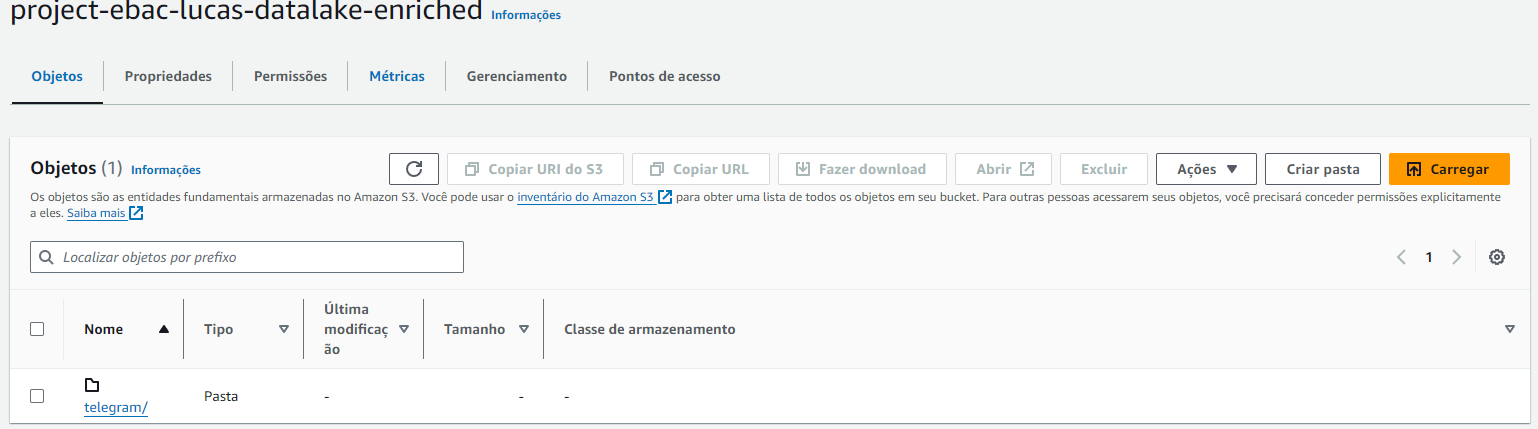

### AWS Lambda

No processo ETL, o `AWS Lambda` é responsável por processar as mensagens captadas pelo bot do Telegram. Para isso, a função do `AWS Lambda` realiza as seguintes etapas:

1. Lista todos os arquivos JSON da camada crua no bucket do `AWS S3`.

2. Para cada arquivo listado:
* Faz o download do arquivo e carrega o conteúdo da mensagem.
* Executa uma função de data wrangling para limpar, padronizar e transformar os dados.
* Cria uma tabela do PyArrow com os dados processados.
* Adiciona a tabela ao final de uma tabela existente.

3. Persiste a tabela no formato Parquet na camada enriquecida no bucket do `AWS S3`.

Notas adicionais:

* O uso de duas camadas de armazenamento e processamento permite que os dados crus sejam reprocessados quantas vezes forem necessárias.
* A função do `AWS Lambda` processa as mensagens do dia anterior (D-1).

O Código da Função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de *data wrangling*:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data



*   **Variáveis de Ambiente**



> Nessa parte estamos adicionamos nossas variáveis de ambiente: `AWS_S3_BUCKET` e `AWS_S3_ENRICHED`, referente aos nossos buckets: `project-ebac-lucas-datalake-raw` e  `project-ebac-lucas-datalake-enriched`.

* **Permissão**

> No `AWS IAM` temos que adicionar a permissão de escrita nos buckets do `AWS S3` para a função do `AWS Lambda`.

* **Recursos**

>O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos.

>  Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

* **Camadas**

Para adicionar pacotes externos no ambiente de execução do AWS Lambda, é necessário criar uma camada ou layer. Uma camada é um pacote de código Python que pode ser compartilhado por várias funções do Lambda.
 Para criar uma camada a partir de um bucket do `AWS S3`, é necessário:

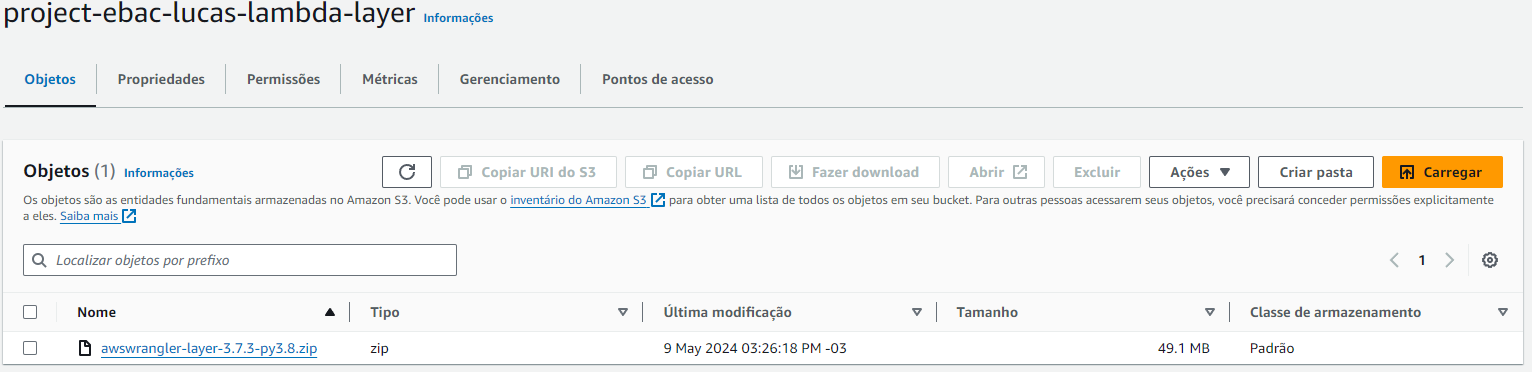

> Aqui criamos o bucket que iremos armazenar o pacote do código fonte do PyArrow.

> Então baixamos um arquivo com os pacotes Python do código-fonte do Pyarrow de interesse. Fazer o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases))

> Carregamos o arquivo no bucket, agora temos que acessar a função lambda e carregar a layer.

> Aqui clicamos em adicionar uma camada.

> Como não temos nenhuma camada, temos que criar uma e passar como caminho o link do bucket que armazenamos o código fonte do PyArrow.

> Agora temos que ir em adicionar uma camada novamente.

> Selecionamos camada personalizada e escolhemos a nossa camada criada. Assim conectamos nossa função com a camada que acabamos de criar.

### AWS Event Bridge

Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler*.

> **Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

> Então definimos uma expressão cronológica para a execução, ou seja, a cada dia a três da manhã o nosso código será executado e ele consumirá o dado do dia anterior, assim ficará disponível para o usuário antes dele acordar.

> Vamos agora nos conectar a um serviço da AWS, no caso a função lambda, nos referindo a função que acabamos de criar.

## Apresentação

A etapa de apresentação de dados é responsável por disponibilizar os dados para os usuários e sistemas que os utilizarão. Essa etapa é a única que a maioria dos usuários terá acesso, portanto, é importante que ela seja fácil de usar e que entregue dados de qualidade. Os dados que são apresentados na etapa de apresentação devem ser armazenados em camadas refinadas. Isso significa que os dados devem estar limpos, padronizados e transformados de forma a atender às necessidades dos usuários. A apresentação de dados de qualidade é essencial para que os usuários possam obter insights e tomar decisões informadas.

### AWS Athena

Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://project-ebac-lucas-datalake-enriched/telegram/'
```

Vamos carregar nossas partições:

```sql
MSCK REPAIR TABLE `telegram`;

```

* **Query-1**: Visualizar as 10 primeiras linhas.

```sql
SELECT * FROM "telegram" LIMIT 10;
```

Mostrando atraves do pandas:

In [43]:
file_url = 'https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_1.csv'
!wget {file_url} -P /content/CSV
df_1 = pd.read_csv("/content/CSV/project-ebac-query_1.csv")
df_1.head(10)

--2024-05-10 13:55:59--  https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1254 (1.2K) [text/plain]
Saving to: ‘/content/CSV/project-ebac-query_1.csv’

project-ebac-query_ 100%[===================>]   1.22K  --.-KB/s    in 0s      

2024-05-10 13:55:59 (62.6 MB/s) - ‘/content/CSV/project-ebac-query_1.csv’ saved [1254/1254]



,message_id,user_id,user_is_bot,user_first_name,chat_id,chat_type,text,date,context_date
0,3,6468181192,False,Lucas,-1002034756065,supergroup,"Olá, mundo!",1715261875,2024-05-09
1,3,6468181192,False,Lucas,-1002034756065,supergroup,"Olá, mundo!",1715261875,2024-05-09
2,4,6468181192,False,Lucas,-1002034756065,supergroup,teste,1715261944,2024-05-09
3,5,6468181192,False,Lucas,-1002034756065,supergroup,Ultima etapa!!,1715274965,2024-05-09
4,6,6468181192,False,Lucas,-1002034756065,supergroup,Oi,1715277826,2024-05-09
5,7,6468181192,False,Lucas,-1002034756065,supergroup,testando integração,1715277836,2024-05-09
6,8,6468181192,False,Lucas,-1002034756065,supergroup,API e ingestão de dados pelo AWS,1715277855,2024-05-09
7,9,6468181192,False,Lucas,-1002034756065,supergroup,Primeiro dia do projeto,1715281217,2024-05-09
8,10,6468181192,False,Lucas,-1002034756065,supergroup,testando a variação de tamanho de mensagem par...,1715281914,2024-05-09
9,11,6468181192,False,Lucas,-1002034756065,supergroup,Ultimo teste do dia,1715282078,2024-05-09


> Aqui visualizamos as dez primeiras linhas dos dados do bot, incluindo o nome do usuário, a mensagem enviada e a data de envio.

### Analytics

Com o dado disponível, usuário podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:



*  **Query_2**: Quantidade de mensagens por dia.



```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

In [44]:
file_url = 'https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_2.csv'
!wget {file_url} -P /content/CSV
df_2 = pd.read_csv("/content/CSV/project-ebac-query_2.csv")
df_2.head(10)

--2024-05-10 13:56:42--  https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50 [text/plain]
Saving to: ‘/content/CSV/project-ebac-query_2.csv’

project-ebac-query_ 100%[===================>]      50  --.-KB/s    in 0s      

2024-05-10 13:56:42 (2.48 MB/s) - ‘/content/CSV/project-ebac-query_2.csv’ saved [50/50]



,context_date,message_amount
0,2024-05-09,11


> Aqui temos a contagem de mensagens enviadas de acordo com o dia.

* **Query_3**: Quantidade de mensagens por usuário e por dia.

```sql
  SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

In [45]:
file_url = 'https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_3.csv'
!wget {file_url} -P /content/CSV
df_3 = pd.read_csv("/content/CSV/project-ebac-query_3.csv")
df_3.head(10)

--2024-05-10 13:57:11--  https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99 [text/plain]
Saving to: ‘/content/CSV/project-ebac-query_3.csv’

project-ebac-query_ 100%[===================>]      99  --.-KB/s    in 0s      

2024-05-10 13:57:11 (1.21 MB/s) - ‘/content/CSV/project-ebac-query_3.csv’ saved [99/99]



,user_id,user_first_name,context_date,message_amount
0,6468181192,Lucas,2024-05-09,11


> Agora temos a contagem de mensagens de acordo com o id do usuário, o primeior nome do usuário e a data.

* **Query_4**: Média do tamanho das mensagens por usuário e por dia.

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

In [46]:
file_url = 'https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_4.csv'
!wget {file_url} -P /content/CSV
df_4 = pd.read_csv("/content/CSV/project-ebac-query_4.csv")
df_4.head(10)

--2024-05-10 13:57:36--  https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_4.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107 [text/plain]
Saving to: ‘/content/CSV/project-ebac-query_4.csv’

project-ebac-query_ 100%[===================>]     107  --.-KB/s    in 0s      

2024-05-10 13:57:36 (4.94 MB/s) - ‘/content/CSV/project-ebac-query_4.csv’ saved [107/107]



,user_id,user_first_name,context_date,average_message_length
0,6468181192,Lucas,2024-05-09,20


> Aqui temos a média do comprimento das mensagens de acordo com o usuário e a data de envio.

* **Query_5**: Quantidade de mensagens por hora, por dia da semana e por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

In [47]:
file_url = 'https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_5.csv'
!wget {file_url} -P /content/CSV
df_5 = pd.read_csv("/content/CSV/project-ebac-query_5.csv")
df_5.head(10)

--2024-05-10 13:57:58--  https://raw.githubusercontent.com/LucasLLimeira/Pipeline_telegram/main/Query/project-ebac-query_5.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152 [text/plain]
Saving to: ‘/content/CSV/project-ebac-query_5.csv’

project-ebac-query_ 100%[===================>]     152  --.-KB/s    in 0s      

2024-05-10 13:57:58 (2.62 MB/s) - ‘/content/CSV/project-ebac-query_5.csv’ saved [152/152]



,parsed_date_hour,parsed_date_weekday,parsed_date_weeknum,message_amount
0,19,4,19,4
1,13,4,19,3
2,17,4,19,1
3,18,4,19,3


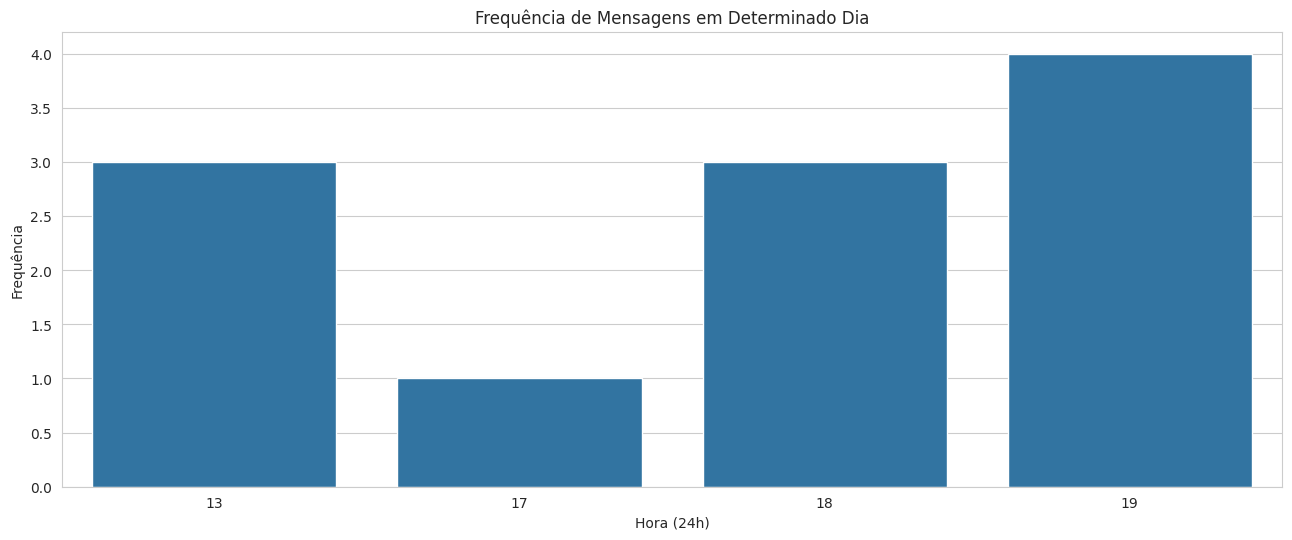

In [48]:
with sns.axes_style('whitegrid'):

  chart = sns.barplot(x='parsed_date_hour', y='message_amount', data=df_5)
  chart.set(title='Frequência de Mensagens em Determinado Dia', xlabel='Hora (24h)', ylabel='Frequência');
  chart.figure.set_size_inches(w=40/2.54, h=15/2.54)

> Aqui temos a quantidade de mensagens enviadas para o bot do telegram por hora, dia da semana e semana do ano. Ele organiza os resultados de forma que seja fácil identificar padrões e tendências nas mensagens enviadas.

## Conclusão

Vimos como a automação de um bot no Telegram pode ser utilizada para tarefas de análise de dados com o uso de funções Python. Trabalhamos em etapas como ingestão dos dado, por meio do bot no Telegram, que seria processo de coleta de dados e transferência de dados brutos para um sistema de armazenamento central, contribuindo para a disponibilidade dos dados para processamento e análise, além de garantirmos a qualidade e integridade dos dados. Tivemos a etapa de ETL, que envolveu a extração e transformação de dados para atender as necessidades do usuário final. E também a etapa de apresentação A apresentação, responsável por fornecer aos usuários as informações de que precisam para tomar decisões informadas mediante consultas que podem ser realizadas por analistas e cientistas, por exemplo.

## Referências

* https://ebaconline.com.br/
* https://github.com/andre-marcos-perez/data-pipeline-demo